# Introduction

Now we have an idea of three important components to analyzing neuroimaging data:

1. Data manipulation
2. Cleaning and confound regression
3. Parcellation and signal extraction

In this notebook the goal is to integrate these 3 basic components and perform a full analysis of group data using **Intranetwork Functional Connectivity (FC)**.

Intranetwork functional connectivity is essentially a result of performing correlational analysis on mean signals extracted from two ROIs. Using this method we can examine how well certain resting state networks, such as the **Default Mode Network (DMN)**, are synchronized across spatially distinct regions.

ROI-based correlational analysis forms the basis of many more sophisticated kinds of functional imaging analysis.

## Using Nilearn's High-level functionality to compute correlation matrices

Nilearn has a built in function for extracting timeseries from functional files and doing all the extra signal processing at the same time. Let's walk through how this is done

First we'll grab our imports as usual


In [1]:
from nilearn import image as nimg
from nilearn import plotting as nplot
import numpy as np
import pandas as pd
from bids import BIDSLayout

Let's grab the data that we want to perform our connectivity analysis on using PyBIDS:


In [2]:
#Use PyBIDS to parse BIDS data structure
fmriprep_dir = "../data/ds000030/derivatives/fmriprep/"
layout = BIDSLayout(fmriprep_dir,
                   config=['bids','derivatives'])

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [4]:
#Get resting state data (preprocessed, mask, and confounds file)
func_files = layout.get(datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')

mask_files = layout.get(datatype='func', task='rest',
                        desc='brain',
                        suffix="mask",
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')

confound_files = layout.get(datatype='func',
                            task='rest',
                            desc='confounds',
                            extension='tsv',
                            return_type='file')

Now that we have a list of subjects to peform our analysis on, let's load up our parcellation template file


In [5]:
#Load separated parcellation
parcel_file = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz'
yeo_7 = nimg.load_img(parcel_file)

Now we'll import a package from <code>nilearn</code>, called <code>input_data</code> which allows us to pull data using the parcellation file, and at the same time applying data cleaning!

We first create an object using the parcellation file <code>yeo_7</code> and our cleaning settings which are the following:

Settings to use:
- Confounders: X, Y, Z, RotX, RotY, RotZ, aCompCor01, aCompCor02, Global Signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True


In [6]:
from nilearn import input_data

# Make sure Yeo atlas is loaded
parcel_file = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz' 
yeo_7 = nimg.load_img(parcel_file)
masker = input_data.NiftiLabelsMasker(labels_img=parcel_file,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=2)

The object <code>masker</code> is now able to be used on *any functional image of the same size*. The `input_data.NiftiLabelsMasker` object is a wrapper that applies parcellation, cleaning and averaging to an functional image. For example let's apply this to our first subject:

In [7]:
# Pull the first subject's data
func_file = func_files[0]
mask_file = mask_files[0]
confound_file = confound_files[0]

Before we go ahead and start using the <code>masker</code> that we've created, we have to do some preparatory steps. The following should be done prior to use the <code>masker</code> object:
1. Make your confounds matrix (as we've done in Episode 06)
2. Drop Dummy TRs that are to be excluded from our cleaning, parcellation, and averaging step

To help us with the first part, let's define a function to help extract our confound regressors from the .tsv file for us. Note that we've handled pulling the appropriate `{confounds}_derivative1` columns for you! You just need to supply the base regressors!


In [11]:
#Refer to part_06 for code + explanation
def extract_confounds(confound_tsv,confounds,dt=True):
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confounds                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    if dt:    
        dt_names = ['{}_derivative1'.format(c) for c in confounds]
        confounds = confounds + dt_names
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
 
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat

Finally we'll set up our image file for confound regression (as we did in Episode 6). To do this we'll drop 4 TRs from *both our functional image and our confounds file*. Note that our <code>masker</code> object will not do this for us!


In [12]:
#Load functional image
tr_drop = 4
func_img = nimg.load_img(func_file)

#Remove the first 4 TRs
func_img = func_img.slicer[:,:,:,tr_drop:]

#Use the above function to pull out a confound matrix
confounds = extract_confounds(confound_file,
                              ['trans_x','trans_y','trans_z',
                               'rot_x','rot_y','rot_z',
                               'global_signal',
                               'white_matter','csf'])
#Drop the first 4 rows of the confounds matrix
confounds = confounds[tr_drop:,:] 

### Using the masker
Finally with everything set up, we can now use the masker to perform our:
1. Confounds cleaning
2. Parcellation
3. Averaging within a parcel
All in one step!


In [13]:
#Apply cleaning, parcellation and extraction to functional data
cleaned_and_averaged_time_series = masker.fit_transform(func_img,confounds)
cleaned_and_averaged_time_series.shape

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:313: UserWarning: Persisting input arguments took 1.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


(148, 43)

Just to be clear, this data is *automatically parcellated for you, and, in addition, is cleaned using the confounds you've specified!*

The result of running <code>masker.fit_transform</code> is a matrix that has:
- Rows matching the number of timepoints (148)
- Columns, each for one of the ROIs that are extracted (43)

**But wait!**

We originally had **46 ROIs**, what happened to 3 of them? It turns out that <code>masker</code> drops ROIs that are empty (i.e contain no brain voxels inside of them), this means that 3 of our atlas' parcels did not correspond to any region with signal! To see which ROIs are kept after computing a parcellation you can look at the <code>labels_</code> property of <code>masker</code>:

In [14]:
print(masker.labels_)
print("Number of labels", len(masker.labels_))

[1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49]
Number of labels 43


This means that our ROIs of interest (44 and 46) cannot be accessed using the 44th and 46th columns directly! Instead we'll have to figure out which of the 43 columns correspond to ROI 44 and ROI 46. This can be done as follows:

In [15]:
ROI_44 = masker.labels_.index(44)
ROI_46 = masker.labels_.index(46)

print(ROI_44)
print(ROI_46)

38
40


This means that the:
- 38th column is ROI 44
- 40th column is ROI 46

We stored them in the <code>ROI_44</code> and <code>ROI_46</code> variables so we can use these later!

### Calculating Connectivity

In fMRI imaging, connectivity typically refers to the *correlation of the timeseries of 2 ROIs*. Therefore we can calculate a *full connectivity matrix* by computing the correlation between *all pairs of ROIs* in our parcellation scheme! 

We'll use another nilearn tool called <code>ConnectivityMeasure</code> from <code>nilearn.connectome</code>. This tool will perform the full set of pairwise correlations for us

In [16]:
from nilearn.connectome import ConnectivityMeasure

Like the masker, we need to make an object that will calculate connectivity for us.

In [17]:
correlation_measure = ConnectivityMeasure(kind='correlation')

Try using <code>SHIFT-TAB</code> to see what options you can put into the <code>kind</code> argument of <code>ConnectivityMeasure</code>


Then we use <code>correlation_measure.fit_transform()</code> in order to calculate the full correlation matrix for our parcellated data!


In [18]:
full_correlation_matrix = correlation_measure.fit_transform([cleaned_and_averaged_time_series])
full_correlation_matrix.shape

(1, 43, 43)

Note that we're using a list <code>[cleaned_and_averaged_time_series]</code>, this is becasue <code>correlation_measure</code> works on a *list of subjects*. We'll take advantage of this later!


The result is a matrix which has:

- A number of rows matching the number of ROIs in our parcellated data
- A number of columns, that also matches the number of ROIs in our parcellated data

Suppose we wanted to know the correlation between ROI 44 and ROI 46. To get this value we need look at the row and column indices that correspond to these ROIs!

Recall that since we lost 3 columns, we had to use the <code>masker.labels_</code> property to figure out which column corresponds to which of the atlas' original ROIs:

In [19]:
full_correlation_matrix[0, ROI_44, ROI_46]

0.41261168793947856

## Exercise

Apply the data extract process shown above to all subjects in our subject list and collect the results. Your job is to fill in the blanks!


In [21]:
# First we're going to create some empty lists to store all our data in!
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []

#Which confound variables should we use?
confound_variables = ['trans_x','trans_y','trans_z',
                               'rot_x','rot_y','rot_z',
                               'global_signal',
                               'white_matter','csf']

# Lets get all the subjects we have
subjects = layout.get_subjects()
for sub in subjects:
    
    #Get the functional file for the subject (MNI space)
    func_file = layout.get(subject=sub,
                           datatype='func', task='rest',
                           desc='preproc',
                           extension="nii.gz",
                           return_type='file')[0]
    
    #Get the confounds file for the subject (MNI space)
    confound_file=layout.get(subject=sub, datatype='func',
                             task='rest',
                             desc='confounds',
                             extension='tsv',
                             return_type='file')[0]
    
    #Load the functional file in
    func_img = nimg.load_img(func_file)
    
    #Drop the first 4 TRs
    func_img = func_img.slicer[:,:,:,tr_drop:]
    
    
    #Extract the confound variables using the function
    confounds = extract_confounds(confound_file,
                                  confound_variables)
    
    #Drop the first 4 rows from the confound matrix
    #Which rows and columns should we keep?
    confounds = confounds[tr_drop:,:]
    
    #Apply the parcellation + cleaning to our data
    #What function of masker is used to clean and average data?
    time_series = masker.fit_transform(func_img,confounds)
    
    #This collects a list of all subjects
    pooled_subjects.append(time_series)
    
    #If the subject ID starts with a "1" then they are control
    if sub.startswith('1'):
        ctrl_subjects.append(time_series)
    #If the subject ID starts with a "5" then they are case (case of schizophrenia)
    if sub.startswith('5'):
        schz_subjects.append(time_series)

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:313: UserWarning: Persisting input arguments took 1.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)
/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:313: UserWarning: Persisting input arguments took 1.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provi

The result of all of this code is that:

1. Subjects who start with a "1" in their ID, are controls, and are placed into the `ctrl_subjects` list
2. Subjects who start with a "2" in their ID, have schizophrenia, and are placed into the `schz_subjects` list

What's actually being placed into the list? The cleaned, parcellated time series data for each subject (the output of <code>masker.fit_transform</code>)!

A helpful trick is that we can re-use the <code>correlation_measure</code> object we made earlier and apply it to a *list of subject data*! 


In [22]:
ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)

At this point, we have correlation matrices for each subject across two populations. The final step is to examine the differences between these groups in their correlation between ROI 43 and ROI 45.


### Visualizing Correlation Matrices and Group Differences

An important step in any analysis is visualizing the data that we have. We've cleaned data, averaged data and calculated correlations but we don't actually know what it looks like! Visualizing data is important to ensure that we don't throw pure nonsense into our final statistical analysis

To visualize data we'll be using a python package called <code>seaborn</code> which will allow us to create statistical visualizations with not much effort.


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

We can view a single subject's correlation matrix by using <code>seaborn</code>'s <code>heatmap</code> function:


<AxesSubplot:>

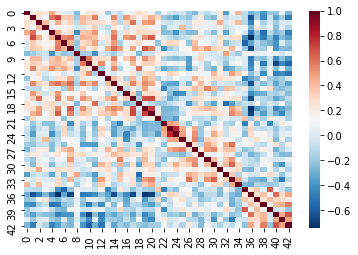

In [24]:
sns.heatmap(ctrl_correlation_matrices[0], cmap='RdBu_r')

We can now pull our ROI 44 and 46 by indexing our list of correlation matrices as if it were a 3D array (kind of like an MR volume). Take a look at the shape:

In [25]:
print(ctrl_correlation_matrices.shape)

(3, 43, 43)


This is of form:

<code>ctrl_correlation_matrices[subject_index, row_index, column_index]</code>

Now we're going to pull out just the correlation values between ROI 43 and 45 *across all our subjects*. This can be done using standard array indexing:

In [26]:
ctrl_roi_vec = ctrl_correlation_matrices[:,ROI_44,ROI_46]
schz_roi_vec = schz_correlation_matrices[:,ROI_44,ROI_46]

Next we're going to arrange this data into a table. We'll create two tables (called dataframes in the python package we're using, `pandas`)


In [27]:
#Create control dataframe
ctrl_df = pd.DataFrame(data={'dmn_corr':ctrl_roi_vec, 'group':'control'})
ctrl_df.head()

,dmn_corr,group
0,0.412612,control
1,0.369671,control
2,0.500275,control


In [28]:
# Create the schizophrenia dataframe
scz_df = pd.DataFrame(data={'dmn_corr':schz_roi_vec, 'group' : 'schizophrenia'})
scz_df.head()

,dmn_corr,group
0,0.237506,schizophrenia


The result is:

- `ctrl_df` a table containing the correlation value for each control subject, with an additional column with the group label, which is 'control'

- `scz_df` a table containing the correlation value for each schizophrenia group subject, with an additional column with the group label, which is 'schizophrenia'

For visualization we're going to stack the two tables together...

In [29]:
#Stack the two dataframes together
df = pd.concat([ctrl_df,scz_df], ignore_index=True)

# Show some random samples from dataframe
df.sample(n=5)

ValueError: Cannot take a larger sample than population when 'replace=False'

Finally we're going to visualize the results using the python package `seaborn`!


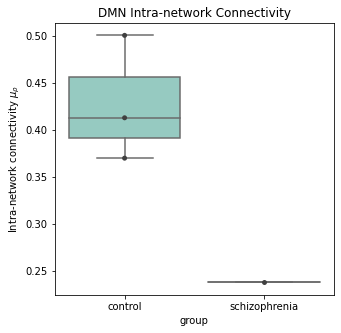

In [30]:
#Visualize results

# Create a figure canvas of equal width and height
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
#the y-axis as the correlation value
ax = sns.boxplot(x='group',y='dmn_corr',data=df,palette='Set3')

# Create a "swarmplot" as well, you'll see what this is..
ax = sns.swarmplot(x='group',y='dmn_corr',data=df,color='0.25')

# Set the title and labels of the figure
ax.set_title('DMN Intra-network Connectivity')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

plt.show()

Although the results here aren't significant they seem to indicate that there might be three subclasses in our schizophrenia group - of course we'd need *a lot* more data to confirm this! The interpretation of these results should ideally be based on some *a priori* hypothesis! 


## Congratulations!

Hopefully now you understand that:

1. fMRI data needs to be pre-processed before analyzing
2. Manipulating images in python is easily done using `nilearn` and `nibabel`
3. You can also do post-processing like confound/nuisance regression using `nilearn`
4. Parcellating is a method of simplifying and "averaging" data. The type of parcellation reflect assumptions you make about the structure of your data
5. Functional Connectivity is really just time-series correlations between two signals!